In [1]:
import pandas as pd
import numpy as np
import math

# Đọc file benchmark và FSB result
benchmark_df = pd.read_csv('../data/owasp/expected_results_320.csv')
fsb_df = pd.read_csv('../data/fsb/fsb_report.csv')

# Chuẩn hoá tên cột benchmark
benchmark_df = benchmark_df.rename(columns={
    '# test name': 'test name',
    ' category': 'category',
    ' real vulnerability': 'real vulnerability'
})
benchmark_df['category'] = benchmark_df['category'].str.lower()
benchmark_df = benchmark_df.drop(['Benchmark version: 1.2', '2016-06-1'], axis=1)

print("\n🔎 Preview benchmark_df:")
print(benchmark_df.head())


🔎 Preview benchmark_df:
            test name    category  real vulnerability  cwe
0  BenchmarkTest01025  pathtraver                True   22
1  BenchmarkTest01238  pathtraver                True   22
2  BenchmarkTest00528  pathtraver                True   22
3  BenchmarkTest00783  pathtraver                True   22
4  BenchmarkTest02378  pathtraver                True   22


In [4]:
# Ánh xạ bug_type sang category theo CWE
bug2cwe = {
    "COMMAND_INJECTION": "cmdi",
    "SPRING_ENDPOINT": "cmdi",
    "XPATH_INJECTION": "xpath",
    "XSS_SERVLET": "xss",
    "XSS_JSP_PRINT": "xss",
    "LDAP_INJECTION": "ldapi",
    "PATH_TRAVERSAL_IN": "pathtraver",
    "PATH_TRAVERSAL_OUT": "pathtraver",
    "SQL_INJECTION": "sqli",
    "SQL_INJECTION_JDBC": "sqli",
    "SQL_INJECTION_JPA": "sqli",
    "SQL_INJECTION_JDO": "sqli",
    "SQL_INJECTION_HIBERNATE": "sqli",
    "SQL_INJECTION_SPRING_JDBC": "sqli",
    "SQL_INJECTION_TURBINE": "sqli",
    "SQL_INJECTION_VERTX": "sqli",
    "SQL_INJECTION_ANDROID": "sqli",
    "SQL_NONCONSTANT_STRING_PASSED_TO_EXECUTE": "sqli",
    "SQL_PREPARED_STATEMENT_GENERATED_FROM_NONCONSTANT_STRING": "sqli",
    "INSECURE_COOKIE": "securecookie",
    "HTTPONLY_COOKIE": "securecookie",
    "TRUST_BOUNDARY_VIOLATION": "trustbound",
    "PREDICTABLE_RANDOM": "weakrand",
    "DES_USAGE": "crypto",
    "TDES_USAGE": "crypto",
    "ECB_MODE": "crypto",
    "CIPHER_INTEGRITY": "crypto",
    "WEAK_MESSAGE_DIGEST_MD5": "hash",
    "WEAK_MESSAGE_DIGEST_SHA1": "hash",
}

# Tách testcase từ source_path trong FSB
fsb_df['testcase'] = fsb_df['source_path'].str.extract(r'(BenchmarkTest\d{5})')

# Ánh xạ bug_type sang category_fsb
fsb_df['category_fsb'] = fsb_df['bug_type'].map(bug2cwe)

# 🌿 Lọc bỏ các dòng không có testcase (cảnh báo ngoài benchmark)
fsb_df = fsb_df[fsb_df['testcase'].notna()]

# 🌿 Lọc bỏ các bug_type không nằm trong bug2cwe (không thuộc 11 CWE)
fsb_df = fsb_df[fsb_df['category_fsb'].notna()]

print("\n🔎 Preview fsb_df (đã lọc chỉ testcase và 11 CWE):")
print(fsb_df[['testcase', 'bug_type', 'category_fsb']].head())

# Gom các category FSB theo testcase
fsb_grouped = fsb_df.groupby('testcase')['category_fsb'].apply(set).reset_index()


🔎 Preview fsb_df (đã lọc chỉ testcase và 11 CWE):
              testcase            bug_type  category_fsb
45  BenchmarkTest00001     HTTPONLY_COOKIE  securecookie
46  BenchmarkTest00001   PATH_TRAVERSAL_IN    pathtraver
49  BenchmarkTest00002     HTTPONLY_COOKIE  securecookie
50  BenchmarkTest00002  PATH_TRAVERSAL_OUT    pathtraver
53  BenchmarkTest00003     HTTPONLY_COOKIE  securecookie


In [5]:
# Merge benchmark và FSB
merged_df = benchmark_df.merge(fsb_grouped, left_on='test name', right_on='testcase', how='left')
merged_df['category_fsb'] = merged_df['category_fsb'].apply(lambda x: x if isinstance(x, set) else set())

print("\n🔎 Preview merged_df:")
print(merged_df[['test name', 'category', 'real vulnerability', 'category_fsb']].head())

# Đánh giá TP, FP, FN, TN
def evaluate(row):
    category_benchmark = row['category']
    category_fsb_set = row['category_fsb']
    real_vuln = row['real vulnerability']

    if real_vuln:  # Benchmark có lỗi
        if category_benchmark in category_fsb_set: 
            return 'TP' # FSB báo CWE đúng category benchmark
        else:
            return 'FN' # FSB không báo category benchmark
    else:  # Benchmark không có lỗi
        if category_benchmark in category_fsb_set:
            return 'FP'  # FSB báo CWE đúng category benchmark
        else:
            return 'TN'  # FSB không báo category benchmark

merged_df['Evaluation'] = merged_df.apply(evaluate, axis=1)
print("\n🔎 Preview merged_df with Evaluation:")
print(merged_df[['test name', 'category', 'real vulnerability', 'category_fsb', 'Evaluation']].head())



🔎 Preview merged_df:
            test name    category  real vulnerability  category_fsb
0  BenchmarkTest01025  pathtraver                True  {pathtraver}
1  BenchmarkTest01238  pathtraver                True  {pathtraver}
2  BenchmarkTest00528  pathtraver                True  {pathtraver}
3  BenchmarkTest00783  pathtraver                True  {pathtraver}
4  BenchmarkTest02378  pathtraver                True  {pathtraver}

🔎 Preview merged_df with Evaluation:
            test name    category  real vulnerability  category_fsb Evaluation
0  BenchmarkTest01025  pathtraver                True  {pathtraver}         TP
1  BenchmarkTest01238  pathtraver                True  {pathtraver}         TP
2  BenchmarkTest00528  pathtraver                True  {pathtraver}         TP
3  BenchmarkTest00783  pathtraver                True  {pathtraver}         TP
4  BenchmarkTest02378  pathtraver                True  {pathtraver}         TP


In [6]:
# 🌿 Tạo file CSV chuẩn từ merged_df (format chuẩn để so sánh multi-tool)
fsb_output_rows = []
for _, row in merged_df.iterrows():
    testcase = row['test name']
    cwe = row['category']
    expected = bool(row['real vulnerability'])
    detected = cwe in row['category_fsb']
    fsb_output_rows.append({
        'TestCase': testcase,
        'CWE': cwe,
        'Expected': expected,
        'Detected': detected
    })

fsb_output_df = pd.DataFrame(fsb_output_rows)

# Lưu file CSV chuẩn (chuẩn format cho multi-tool)
fsb_output_df.to_csv('../data/fsb/fsb_results_format.csv', index=False)
print(f"\n✅ Đã xuất file FSB chuẩn từ merged_df")
print(fsb_output_df.head())


✅ Đã xuất file FSB chuẩn từ merged_df
             TestCase         CWE  Expected  Detected
0  BenchmarkTest01025  pathtraver      True      True
1  BenchmarkTest01238  pathtraver      True      True
2  BenchmarkTest00528  pathtraver      True      True
3  BenchmarkTest00783  pathtraver      True      True
4  BenchmarkTest02378  pathtraver      True      True


In [7]:
# Tạo bảng tổng hợp
summary = merged_df['Evaluation'].value_counts().reset_index()
summary.columns = ['Metric', 'Count']
print("\n📊 Summary TP, FP, FN, TN:")
print(summary)


📊 Summary TP, FP, FN, TN:
  Metric  Count
0     TP    147
1     FP     84
2     TN     76
3     FN     13


In [8]:
# Tính precision, recall, f1-score
TP = summary.loc[summary['Metric'] == 'TP', 'Count'].values[0] if 'TP' in summary['Metric'].values else 0
FP = summary.loc[summary['Metric'] == 'FP', 'Count'].values[0] if 'FP' in summary['Metric'].values else 0
FN = summary.loc[summary['Metric'] == 'FN', 'Count'].values[0] if 'FN' in summary['Metric'].values else 0
TN = summary.loc[summary['Metric'] == 'TN', 'Count'].values[0] if 'TN' in summary['Metric'].values else 0

def metrics_paper(tp: int, fp: int, fn: int, tn: int) -> None:
    rec  = tp / (tp + fn) if tp + fn else 0.0
    prec = tp / (tp + fp) if tp + fp else 0.0
    fpr  = fp / (tn + fp) if tn + fp else 0.0

    # F–scores (β = 1, 0.5, 1.5)
    def fbeta(beta: float) -> float:
        b2 = beta * beta
        return (1 + b2) * prec * rec / (b2 * prec + rec) if (prec + rec) else 0.0

    f1   = fbeta(1)
    f05  = fbeta(0.5)
    f15  = fbeta(1.5)

    # Markedness (TPR+TNR centered)
    denom_mark = math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    mark = ((tp * tn) - (fp * fn)) / denom_mark if denom_mark else 0.0

    # Informedness (Youden J)
    inf  = rec - fpr

    results = {
        "Rec":  rec,
        "FPR":  fpr,
        "Prec": prec,
        "F-Mes": f1,
        "F0.5": f05,
        "F1.5": f15,
        "Mark": mark,
        "Inf":  inf,
    }

    print("\n=== KẾT QUẢ ===")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

    return results

# Gọi hàm với TP, FP, FN, TN của bạn
metrics = metrics_paper(TP, FP, FN, TN)


=== KẾT QUẢ ===
Rec: 0.9187
FPR: 0.5250
Prec: 0.6364
F-Mes: 0.7519
F0.5: 0.6780
F1.5: 0.8084
Mark: 0.4394
Inf: 0.3937


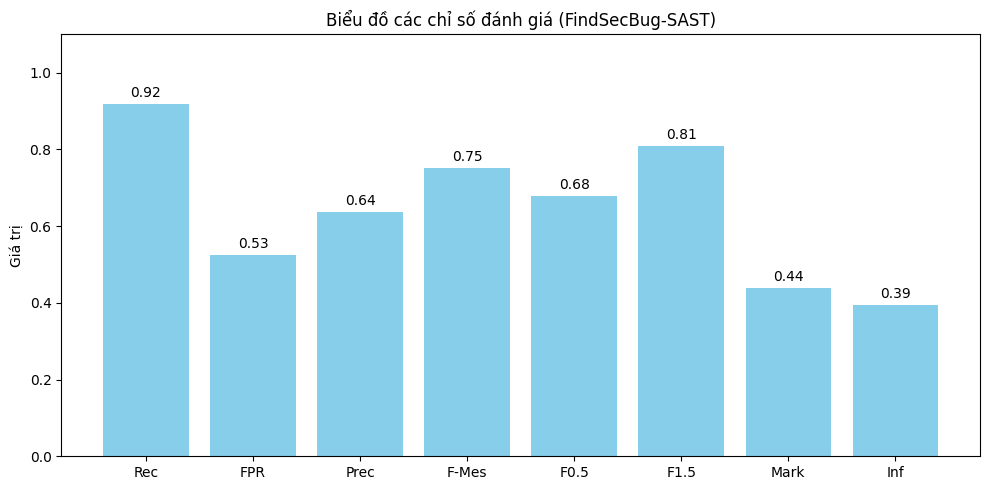

In [9]:
import matplotlib.pyplot as plt

# Chuẩn bị dữ liệu
labels = list(metrics.keys())
values = list(metrics.values())

# Vẽ biểu đồ cột
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(labels, values, color='skyblue')

# Thêm nhãn giá trị trên đầu mỗi cột
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # khoảng cách lên trên
                textcoords="offset points",
                ha='center', va='bottom')

# Cài đặt hiển thị
ax.set_ylim(0, 1.1)
ax.set_ylabel('Giá trị')
ax.set_title('Biểu đồ các chỉ số đánh giá (FindSecBug-SAST)')
plt.xticks()
plt.tight_layout()
plt.show()